### Markov decision process

- Let $p(s'\vert s,a)$ be the probability of transition from state $s$ to state $s'$ when taking action $a$ 
- Let $r = r(s,a,s')$ be the expected reward 

Let us define a simple MDP from this photo: http://bit.ly/2jrNHNr

In [2]:

from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pwd

import os
os.chdir('/content/drive/My Drive/MDP')

/content


In [0]:
# Define the transition probabilities
transition_probs = {
  's0':{
    'a0': {'s0': 0.5, 's2': 0.5},
    'a1':{'s2':1},
  },
   's1': {
       'a0':{'s0':0.7,'s1':0.1,'s2':0.2},
       'a1':{'s1':0.95,'s2':0.05},
   },
   's2':{
       'a0':{'s0':0.4,'s2':0.6},
       'a1':{'s0':0.3,'s1':0.3,'s2':0.4},
   }
}
# Define the rewards
rewards = {
  's1': {'a0': {'s0': +5}},
  's2': {'a1': {'s0': -1}},
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [5]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


Some useful methods of MDP

In [6]:
# Return a tuple of all possible states
print("mdp.get_all_states =", mdp.get_all_states())
# Return a tuple of possible actions in a given state
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
# Return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...}
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
# Return the reward $r(s,a,s')$
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
# Return $P(s'|s,a)$
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))
# Return True if state is a terminal state
print("mdp.is_terminal('s1') = ", mdp.is_terminal('s1'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7
mdp.is_terminal('s1') =  False


### Value Iteration

The goal is to build __V__alue __I__teration algorithm to solve the MDP defined in the last section


VI Algorithm:

---

Initialize array $V$ arbitrarily (e.g. $V(s) = 0$ for all $s \in \mathcal{S}$)

Repeat $\Delta \leftarrow 0$

For each $s \in \mathcal{S} $

$\quad \quad v \leftarrow V(s)$

$ \quad \quad V(s) \leftarrow \max_a \sum_{s^{'}, r} p(s^{'} \vert s,a) [r+\gamma V(s^{'}]$

$\quad \quad  \Delta \leftarrow \max(\Delta, \vert v-V(s) \vert )$

until $\Delta < 0$ (small positive number)

Output a deterministic policy $\pi \approx \pi^{*}$ such that

$\quad \pi(s)=\text{argmax}_a \sum_{s^{'}, r} p(s^{'} \vert s,a) [r+\gamma V(s^{'}] $

---

Let us write a function to compute the state-action value function $q_\pi(s,a)$, defined as follows

$$q_\pi(s,a) = \sum_{s^{'}, r} p(s^{'} \vert s,a) [r+\gamma V(s^{'}]$$


In [0]:
def get_action_value(mdp, state_values, state, action, gamma):
    q = 0
    # Complete this part
    for future_state in mdp.get_next_states(state, action):
      q=q+mdp.get_transition_prob(state, action, future_state)*(mdp.get_reward(state, action, future_state)+gamma*state_values[future_state])
    return q

Using $q(s,a)$ we can now define the "next" V(s) for value iteration:
 $$V(s) \leftarrow \max_a \sum_{s^{'}, r} p(s^{'} \vert s,a) [r+\gamma V(s^{'}] = \max_a q_\pi(s,a)$$

In [0]:
def get_new_state_value(mdp, state_values, state, gamma):
 # Complete this part   
  new_value=-float('inf')
  for action in mdp.get_possible_actions(state):
    q=get_action_value(mdp, state_values, state, action, gamma)
    new_value=max(q,new_value)

  return new_value

We finally combine everything to get $V^{*}(s)$

In [0]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
min_difference = 0.001 # (Delta): stop VI if the difference between new and old values is =<min_difference

# initialize V(s)
state_values={'s0': 0,'s1':0, 's2': 0}
# Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
states=mdp.get_all_states()
for i in range(num_iter):
  new_state_values=dict(state_values)
  diff=0
  for state in states:
    new_state_values[state]=get_new_state_value(mdp, state_values, state, gamma)

# Compute difference
    diff=diff+abs(new_state_values[state]-state_values[state])

# Compare difference with min_difference
  if diff<=min_difference:
    break
  state_values=dict(new_state_values)

In [10]:
print("Final state values:", state_values)
print(i) # pour montrer la convergence


Final state values: {'s0': 3.786840585609628, 's1': 7.299812135929217, 's2': 4.207945987289037}
69


<font color='red'> Voici les values des 3 états, ainsi que le nombre d'itérations. On a 69 iterations < 100 donc on a bien obtenu une convergence des values. La value de s1 est bien plus élevé que celle des deux autres états par conséquent l'algorithme va avoir tendance à se mettre dans l'état s1 pour maximiser sa récompense.</font>

We will use $V^{*}(s)$ to find optimal actions in each state
 
$$\pi^*(s) = \text{argmax}_a \sum_{s^{'}, r} p(s^{'} \vert s,a) [r+\gamma V(s^{'}] = \text{argmax}_a q(s,a) $$

In [0]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
# Complete this part
  q_max=0
  for action in mdp.get_possible_actions(state):
     q=get_action_value(mdp, state_values, state, action, gamma)
     if q>=q_max:
       q_max=q
       optimal_action=action
  return optimal_action

Estimate the agent's average reward using mdp.step function that takes as input action and returns: next_state, reward, is_done, empty_info 

In [12]:
s = mdp.reset() # reset the game, return the initial state
# Complete this part
r=0
for i in range(1,101):
  action=get_optimal_action(mdp,state_values,s,gamma)
  next_state,reward,is_done,empty_info=mdp.step(action)
  r=r+reward/i
  if is_done:
    break
print("average reward =", r)

average reward = -0.5588235294117647


<font color='red'> La récompense moyenne à chaque action est proche de 0.</font>

### Frozen lake
https://gym.openai.com/envs/FrozenLake-v0/

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.
Winter is here. You and your friends were tossing around a frisbee at the park

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:
- SFFF       (S: starting point, safe)
- FHFH       (F: frozen surface, safe)
- FFFH       (H: hole, fall to your doom)
- HFFG       (G: goal, where the frisbee is located)

The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.


In [13]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(map_name="4x4",slip_chance=0) 

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [14]:
print(mdp.get_all_states())
print(mdp.get_possible_actions((0,0)))
print(mdp.get_next_states((0,0), 'left'))

((0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3))
('left', 'down', 'right', 'up')
{(0, 0): 1.0}


Use Value Iteration algorithm to solve the FrozenLake MDP 

In [0]:
def get_new_state_value(mdp, state_values, state, gamma):
 # Complete this part   
  new_value=0
  for action in mdp.get_possible_actions(state):
    q=get_action_value(mdp, state_values, state, action, gamma)
    new_value=max(q,new_value)

  return new_value

In [0]:
def value_iteration(mdp, state_values=None, gamma = 0.9, num_iter = 1000, min_difference = 1e-5):
#""" performs num_iter value iteration steps starting from state_values. Same as before but in a function """    
# Complete this part
  if state_values==None:
    state_values={}
    for i in range(4):
      for j in range(4):
        state_values.update({(i,j):0}) #update: on rajoute cette valeur au dictionnaire
    state_values[(3,3)]=0
  states=mdp.get_all_states()

  for i in range(num_iter):
    new_state_values=dict(state_values)
    diff=0
    for state in states:
      new_state_values[state]=get_new_state_value(mdp, state_values, state, gamma)

      diff=diff+abs(new_state_values[state]-state_values[state])

    if diff<=min_difference:
      break
    state_values=dict(new_state_values)
    state_values[(3,3)]=0       
  return state_values

In [17]:
state_values = value_iteration(mdp)
print(state_values)
print(i)

{(0, 0): 0.5904900000000002, (0, 1): 0.6561000000000001, (0, 2): 0.7290000000000001, (0, 3): 0.6561000000000001, (1, 0): 0.6561000000000001, (1, 1): 0, (1, 2): 0.81, (1, 3): 0, (2, 0): 0.7290000000000001, (2, 1): 0.81, (2, 2): 0.9, (2, 3): 0, (3, 0): 0, (3, 1): 0.9, (3, 2): 1.0, (3, 3): 0}
100


<font color='red'> Voici les values de tous les états. Par exemple si on se trouve à (0,0), comme la value de (0,1) est supérieure à celle de (0,0) et est égale à celle de (1,0) alors on va se diriger vers (0,1) ou (1,0), le choix se fera en considérant les récompenses des actions qui suivront. La value est maximale en (3,2) car c'est la seule case qui permet de passer à la case d'arrivée. </font>

Get and show the optimal actions

In [0]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
# Complete this part
  q_max=0
  optimal_action='up'
  for action in mdp.get_possible_actions(state):
     q=get_action_value(mdp, state_values, state, action, gamma)
     if q>=q_max:
       q_max=q
       optimal_action=action
  return optimal_action

In [19]:
# Complete this part
s = mdp.reset() # reset the game, return the initial state
max_step=10
is_done=False
step=0
while is_done== False and step<=max_step:
  action=get_optimal_action(mdp,state_values,s, gamma)
  s,reward,is_done,empty_info=mdp.step(action)
  print(action)
  step=step+1



right
right
down
down
down
right


<font color='red'> Le chemin optimal est celui affiché au dessus, obtenu en maximisant les q.</font>

### Visualization of the Frozen Lake

In order to visualize what the algorithm is actually learning, we will plot the state value functions and optimal actions at each VI step.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def draw_policy(mdp, state_values):
    plt.figure(figsize=(3,3))
    h,w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w,h), cmap='gray', interpolation='none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down':(0, -1), 'right':(1,0), 'up':(-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y,x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None: continue
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
    plt.grid(color='b', lw=2, ls='-')
    plt.show()



after iteration 0


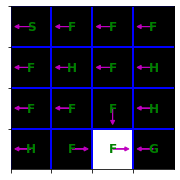

after iteration 1


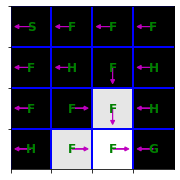

after iteration 2


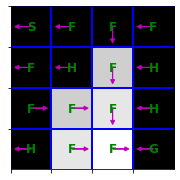

after iteration 3


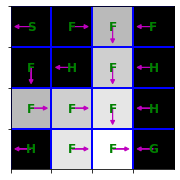

after iteration 4


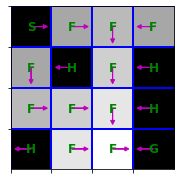

after iteration 5


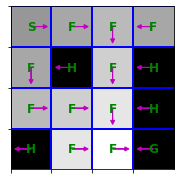

after iteration 6


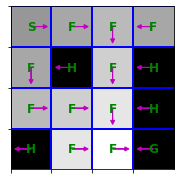

after iteration 7


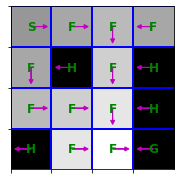

after iteration 8


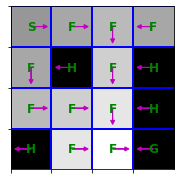

after iteration 9


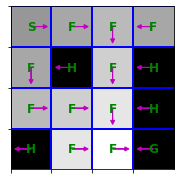

In [21]:
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

<font color='red'>  <font/>

<font color='red'> On retrouve bien notre chemin optimal qu'on a obtenu précedemment:
right
right
down
down
down
right

after iteration 29


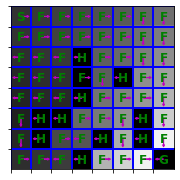

In [22]:
from IPython.display import clear_output
from time import sleep
# Define an 8x8 Frozen Lake with a slip chance of 0.1 
mdp = FrozenLakeEnv(map_name="8x8",slip_chance=0.1)  
state_values = {s : 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i"%i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Understand and comment the following tests with different values of map-name and slip_chance

In [23]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

average reward:  1.0
Well done!


In [24]:
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

average reward:  0.875
Well done!


In [25]:
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

average reward:  0.643
Well done!


In [26]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done: break
    total_rewards.append(np.sum(rewards))
    
print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

KeyError: ignored

<font color='red'> Plus la probabilité de glisser "slip_chance" est élevée, plus on a de chance de prendre la mauvaise case, par conséquent il est logique de voir la recompense moyenne diminuer.